In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

## 1) Setup

In [254]:
M = np.array([0.576, 0.32 , 0.94 , 0.736, 0.996, 0.74 , 0.884, 0.836, 0.748,
       0.768, 0.804, 0.78 , 0.724, 0.68 , 0.656, 0.68 , 0.688, 0.72 ,
       0.768, 0.764, 0.816, 0.74 , 0.336, 0.628, 0.544, 0.664, 0.628,
       0.664, 0.604, 0.596, 1.236, 0.516, 0.608, 0.588, 0.616, 0.612,
       0.612, 0.608, 0.592, 0.584, 0.588, 0.592, 0.624, 0.668, 0.66 ,
       0.696, 0.708, 0.688, 0.744, 0.844, 0.932, 0.964, 1.012, 0.956,
       0.488, 0.424, 1.028, 0.824, 0.916, 0.9  , 0.904, 0.892, 0.876,
       0.784, 0.42 , 0.332, 0.768, 0.744, 0.78 , 0.832, 0.48 , 0.408,
       0.896, 0.896, 0.784, 0.744, 0.68 , 0.768, 0.596, 0.724, 0.676,
       0.644, 0.688, 0.728, 0.74 , 0.724, 0.74 , 0.772, 0.816, 0.832,
       0.828, 0.82 , 0.808, 0.8  , 0.76 , 0.732, 0.692, 0.712, 0.772,
       0.8  ])

# N = np.size(M)
N = 2

sigVScalar = 1e-3
sigXScalar = 1e-2

d = 1
mu0 = np.array([-0.91861314, 0.60239937])
alphahat = 41.3

# mu0 = np.array([1.2850724, -4.20921224])
# alphahat = 171.3713713713714
sigv = np.identity(d+1)*sigVScalar
sig0 = np.identity(d+1)*sigXScalar

precisionv = np.linalg.inv(sigv)
precision0 = np.linalg.inv(sig0)


h = np.ones((d+1, N))
for k in range(N):
    h[1:min(d+1, k)+1, k] = M[max(k-d,0):k][::-1]

## 2) Langevin Monte Carlo

In [192]:
def lmcIteration(xk, eps, g):
    '''
    xk = current x vector
    eps = step size scalar
    g = gradient of f
    '''

    (n,) = xk.shape
    zk = np.random.multivariate_normal(np.zeros_like(xk), np.eye(n))
    x_plus = xk - eps**2/2 * g + eps*zk
    return x_plus

def logPx(x):
    (_, N) = x.shape
    logp = stats.multivariate_normal.logpdf(x[:,0], mu0, sig0)
    for j in range(1, N):
        logp += stats.multivariate_normal.logpdf(x[:,j], x[:,j-1], sigv)
    
    for j in range(N):
        beta = alphahat * np.exp(-h[:,j].T @ x[:,j])
        logp += stats.gamma.logpdf(M[j], a=alphahat, loc=0, scale=1/beta)
    return logp

def gradientX(x, prevX, postX, prePrec, postPrec, alphahat, y, h):
    g = prePrec @ (x - prevX) - postPrec @ (postX - x) \
        + alphahat * h - alphahat * y * np.exp(-h.T @ x) * h
    
    return g

def accept(x_plus, xk, eps, g, gNew):
    (d1, N) = xk.shape
    qNewGivenOld = 0
    qOldGivenNew = 0
    for j in range(N):
        qNewGivenOld += stats.multivariate_normal.logpdf(x_plus[:,j], xk[:,j] - eps**2/2 * g[:,j], eps**2*np.eye(d1))
        qOldGivenNew += stats.multivariate_normal.logpdf(xk[:,j], x_plus[:,j] - eps**2/2 *gNew[:,j], eps**2*np.eye(d1))

    logPNew = logPx(x_plus)
    logPOld = logPx(xk)

    acceptProb = min(1, np.exp(logPNew + qOldGivenNew - logPOld - qNewGivenOld))
    acceptRes = stats.bernoulli.rvs(acceptProb)
    # print(acceptProb, acceptRes)
    
    return acceptRes

In [363]:
S = 10000

def runLMC(ma = True, eps=0.001):
    # initialize
    xSamps = np.zeros((d+1, N, S))
    xSamps[:,0,0] = np.random.multivariate_normal(mu0, sig0)

    burnIn = 1000

    for i in range(1,N):
        xSamps[:,i,0] = np.random.multivariate_normal(xSamps[:,i-1,0], sigv)

    k = 1
    kBurn = 0
    gNew = np.empty((d+1, N))

    gs = np.empty((d+1, N))
    for j in range(N):
        if j == 0:
            prevX = mu0; postX = xSamps[:,j+1,k-1]
            prePrec = precision0; postPrec = precisionv
        elif j == N-1:
            prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j,k-1]
            prePrec = precisionv; postPrec = precisionv
        else:
            prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j+1,k-1]
            prePrec = precisionv; postPrec = precisionv
        gs[:,j] = gradientX(xSamps[:,j,0], prevX, postX, prePrec, postPrec, alphahat, M[j], h[:,j])

    while k < S:
        newSamp = np.empty((d+1, N))

        for j in range(N):
            if j == 0:
                prevX = mu0; postX = xSamps[:,j+1,k-1]
                prePrec = precision0; postPrec = precisionv
            elif j == N-1:
                prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j,k-1]
                prePrec = precisionv; postPrec = precisionv
            else:
                prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j+1,k-1]
                prePrec = precisionv; postPrec = precisionv
            currX = xSamps[:,j,k-1]

            # gs[:,j] = gradientX(currX, prevX, postX, prePrec, postPrec, alphahat, M[j], h[:,j])
            newSamp[:,j] = lmcIteration(currX, eps, gs[:,j])
            
            gNew[:,j] = gradientX(newSamp[:,j], prevX, postX, prePrec, postPrec, alphahat, M[j], h[:,j])
        
        if kBurn <= burnIn:
            kBurn += 1
            xSamps[:,:,0] = newSamp
            gs = gNew.copy()
        else:
            if not ma or accept(newSamp, xSamps[:,:,k-1], eps, gs, gNew):
                xSamps[:,:,k] = newSamp
                gs = gNew.copy()
            else:
                xSamps[:,:,k] = xSamps[:,:,k-1].copy()
            k += 1

    return xSamps


In [361]:
xSamps = runLMC(ma = False)
xSampsMa = runLMC(ma = True)
print(xSamps.shape)
# print(xSamps[0,0,:])

(2, 2, 1000)


In [367]:
epsVals = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2])
xdevNoMa = np.zeros_like(epsVals)
xdevMa = np.zeros_like(epsVals)
for i in range(epsVals.size):
     
    currXSampNoMA = runLMC(ma=False, eps=epsVals[i])
    currXSampMA = runLMC(ma = True, eps=epsVals[i])

    xdevNoMa[i] = np.std(currXSampNoMA[0,0,:])
    xdevMa[i] = np.std(currXSampMA[0,0,:])



[[[-0.99760567 -0.98687826 -0.97679062 ... -0.92452835 -0.9297808
   -0.93353051]
  [-1.00625932 -1.00682489 -1.00110119 ... -0.89779242 -0.89760342
   -0.88687475]]

 [[ 0.40919305  0.43303898  0.43160861 ...  0.65556807  0.65203654
    0.64408072]
  [ 0.42411323  0.41164369  0.41043791 ...  0.70421698  0.6887472
    0.69460411]]]


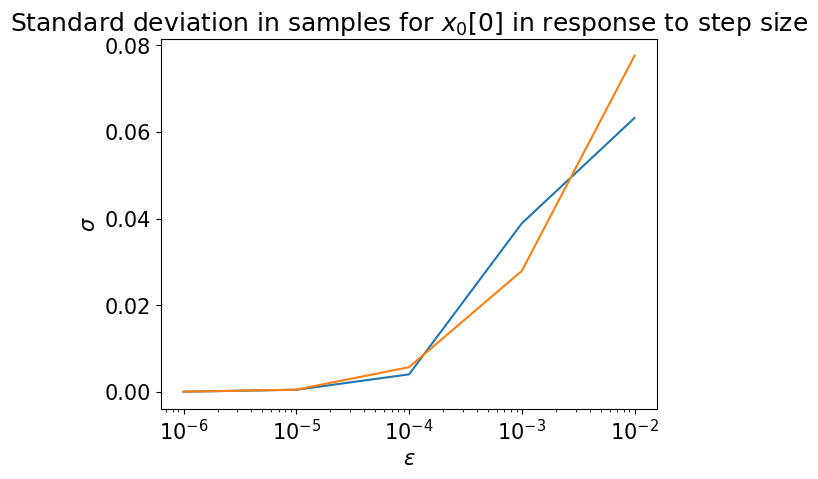

In [370]:
print(currXSampNoMA)

plt.semilogx(epsVals, xdevNoMa)
plt.semilogx(epsVals, xdevMa)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\sigma$ of $x_0[0]$")
plt.title(r"Step size vs. standard deviat$x_0[0]$ in response to step size")
plt.show()

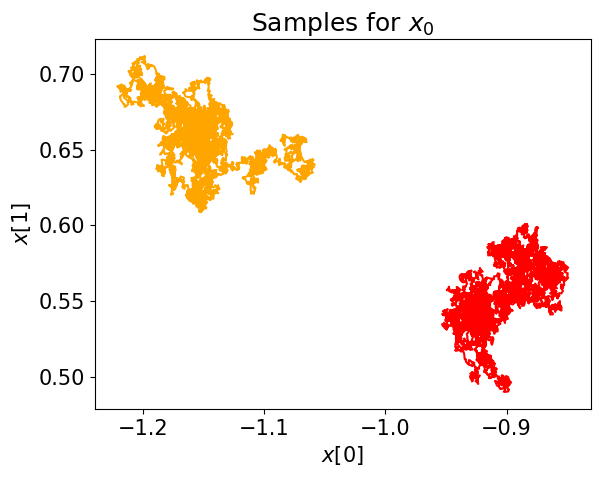

In [331]:
plotN = 0

# xSampsMala = xSamps.copy()
plt.plot(xSamps[0,plotN,:], xSamps[1,plotN,:], color="red")
plt.plot(xSampsMa[0,plotN,:], xSampsMa[1,plotN,:], color="orange")
# plt.scatter(xSamps[0,plotN,0:2], xSamps[1,plotN,0:2])
plt.xlabel(r"$x$[0]")
plt.ylabel(r"$x$[1]")
plt.title(rf"Samples for $x_{{{plotN}}}$")

plt.show()

## 3) Estimate expectation with LMC

In [299]:
h = np.ones((d+1, N))
for k in range(N):
    h[1:min(d+1, k)+1, k] = M[max(k-d,0):k][::-1]
    
def evalExpectationApprox(xSamps):
    (_, N, S) = xSamps.shape
    expectation = 0
    for k in range(S):
        betas = alphahat * np.exp(-np.sum(np.multiply(h, xSamps[:,:,k]), axis=0))
        for j in range(N):
            expectation += 1/S * stats.gamma.logpdf(M[j], a=alphahat, loc=0, scale=1/betas[j])
    return expectation

[[1.    1.   ]
 [1.    0.576]]


In [333]:
currXSamps = runLMC(ma=True)

In [334]:
currXSamps = runLMC(ma=True)
expec = evalExpectationApprox(currXSamps)
print(expec)

-0.4645695314032401


In [337]:
numTrials = 100
expResultsMa = np.zeros((numTrials,))
expResults = np.zeros((numTrials,))

startTime = time.time()
for i in range(numTrials):
    print(i)
    # if i % 100 == 0:
    #     currTime = time.time()
    #     print("Trial ", i, " Time (s): ", currTime - startTime)
    #     startTime = currTime
        
    currXSampsMa = runLMC(ma=True)
    currXSamps = runLMC(ma = False)

    expResultsMa[i] = evalExpectationApprox(currXSampsMa)
    expResults[i] = evalExpectationApprox(currXSamps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


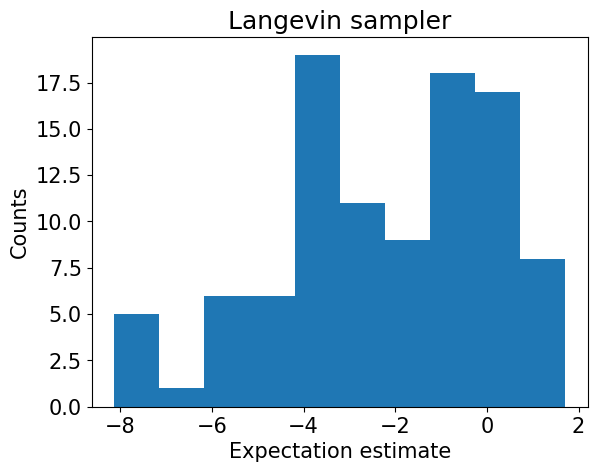

In [339]:
plt.hist(expResults)
plt.xlabel("Expectation estimate")
plt.ylabel("Counts")
plt.title("Langevin sampler")
plt.show()

## 4) Importance sampling

In [158]:
from importanceSamp import *

0


/Users/sabrinaliu/Classes/ee364b/finalProject/importanceSamp.py:51: RuntimeWarning: overflow encountered in exp
  + np.log(1 + np.sum(np.exp(w0LogFinal[1:] + logFuncVals[1:] - w0LogFinal[0] - logFuncVals[0])))
/Users/sabrinaliu/Classes/ee364b/finalProject/importanceSamp.py:52: RuntimeWarning: overflow encountered in exp
  logCoeffDenom = w0LogFinal[0] + np.log(1 + np.sum(np.exp(w0LogFinal[1:] - w0LogFinal[0])))
/Users/sabrinaliu/Classes/ee364b/finalProject/importanceSamp.py:55: RuntimeWarning: invalid value encountered in scalar subtract
  expectation = np.exp(logCoeffNum  - logCoeffDenom) + funcValsMin - eps


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


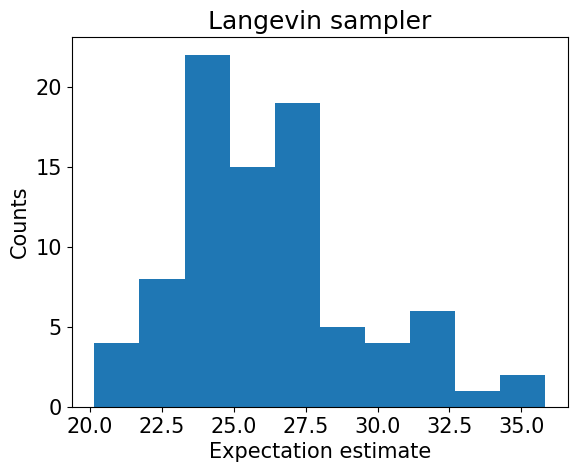

In [343]:
S = 1000
expResultsImportance = np.zeros((numTrials,))
for i in range(numTrials):
    print(i)
    expResultsImportance[i] = importanceSamp(S, alphahat, M, d, mu0, sig0, sigv)
plt.hist(expResultsImportance)
plt.xlabel("Expectation estimate")
plt.ylabel("Counts")
plt.title("Langevin sampler")
plt.show()

In [354]:
sdevsMa = np.zeros((10,))
sdevsNoMa = np.zeros((10,))
sdevsImp = np.zeros((10,))

for i in range(1,11):
    sdevsMa[i-1] = np.std(expResultsMa[:10*i])
    sdevsNoMa[i-1] = np.std(expResults[:10*i])
    sdevsImp[i-1] = np.nanstd(expResultsImportance[:10*i])


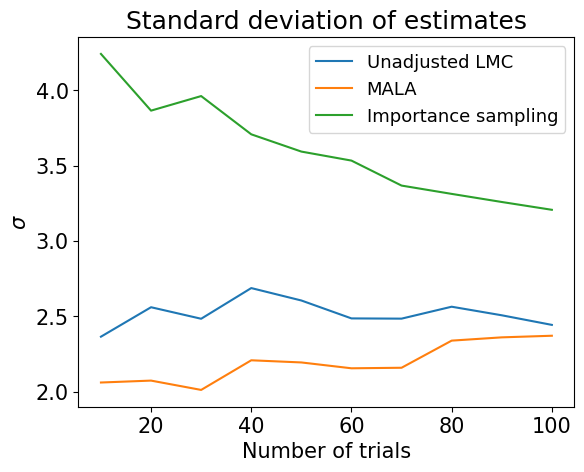

In [360]:
idces = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.plot(idces, sdevsNoMa, label="Unadjusted LMC")
plt.plot(idces, sdevsMa, label="MALA")
plt.plot(idces, sdevsImp, label="Importance sampling")
plt.xlabel("Number of trials")
plt.ylabel(r"$\sigma$")
plt.title("Standard deviation of estimates")
plt.legend(prop={'size':13})
plt.show()


## 5) Plot the density in background

In [300]:
xVals = np.arange(-0.5, 0.51, 0.05)
pdfVals = np.zeros((xVals.size, xVals.size))

beta0s = np.empty((xVals.size, xVals.size))
for i1 in range(xVals.size):
    for i2 in range(xVals.size):
        beta0s[i1, i2] = alphahat * np.exp(-xVals[i1] - xVals[i2])

beta1s = np.empty((xVals.size, xVals.size)) * alphahat
for i1 in range(xVals.size):
    for i2 in range(xVals.size):
        beta1s[i1, i2] = alphahat * np.exp(-xVals[i1] - xVals[i2]*M[0])

for x00Idx in range(xVals.size):
    print(x00Idx)
    for x01Idx in range(xVals.size):
        x0 = np.array([xVals[x00Idx], xVals[x01Idx]]) + mu0
        for x10Idx in range(xVals.size):
            for x11Idx in range(xVals.size):
                x1 = np.array([xVals[x10Idx], xVals[x11Idx]]) + mu0
                pdfVals[x00Idx, x01Idx] = pdfVals[x00Idx, x01Idx] + \
                    stats.multivariate_normal.pdf(x1, x0, sigv) * stats.gamma.pdf(M[1], a=alphahat, loc=0, scale=1/beta1s[x10Idx, x11Idx])
        pdfVals[x00Idx, x01Idx] = pdfVals[x00Idx, x01Idx] \
            * stats.multivariate_normal.pdf(x0, mu0, sig0) * stats.gamma.pdf(M[0], a=alphahat, loc=0, scale=1/beta0s[x00Idx, x01Idx])

pdfVals = pdfVals / np.sum(pdfVals)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [284]:
print(mu0)
print(xVals[0])
print(np.array([xVals[0], xVals[0]]) + mu0)

[-0.91861314  0.60239937]
-0.5
[-1.41861314  0.10239937]


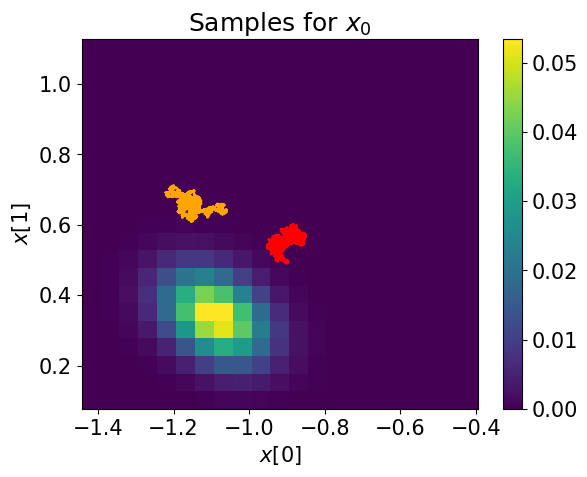

In [332]:
# pdfVals = pdfVals / np.sum(pdfVals)
# print(np.sum(pdfVals))
plt.rcParams.update({'font.size': 15})
x1, x2 = np.meshgrid(xVals+mu0[0], xVals+mu0[1])
plt.pcolormesh(x1, x2, pdfVals)
plt.plot(xSamps[0,plotN,:], xSamps[1,plotN,:], color='red')
plt.plot(xSampsMa[0,plotN,:], xSampsMa[1,plotN,:], color='orange')
plt.xlabel(r"$x$[0]")
plt.ylabel(r"$x$[1]")
plt.title(rf"Samples for $x_{0}$")
plt.colorbar()
plt.show()

In [290]:
print(mu0)

[-0.91861314  0.60239937]


In [ ]:
print(xSamps[])

In [ ]:
varNoMa = np.zeros((10,))
varMa = np.zeros((10,))

for i in range(10):
    np.s